In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import os
import pywt
import numpy as np
import csv
from scipy import stats
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 


In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec
path = os.path.join(os.getcwd(),'mitbih_database')
window_size = 900
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(os.path.join(path, filename + file_extension))

    # *.txt
    else:
        annotations.append(os.path.join(path, filename + file_extension))
print(records)

['d:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\100.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\101.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\102.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\103.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\104.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\105.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\106.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\107.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\108.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\109.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\111.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\112.csv', 'd:\\Projects\\verilogECG\\machineLearningPart2\\mitbih_database\\113.csv', 'd:\\Projec

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\manug\AppData\Local\Temp\ipykernel_17324\1157452981.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\manug\AppData\Local\Temp\ipykernel_17324\1157452981.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:


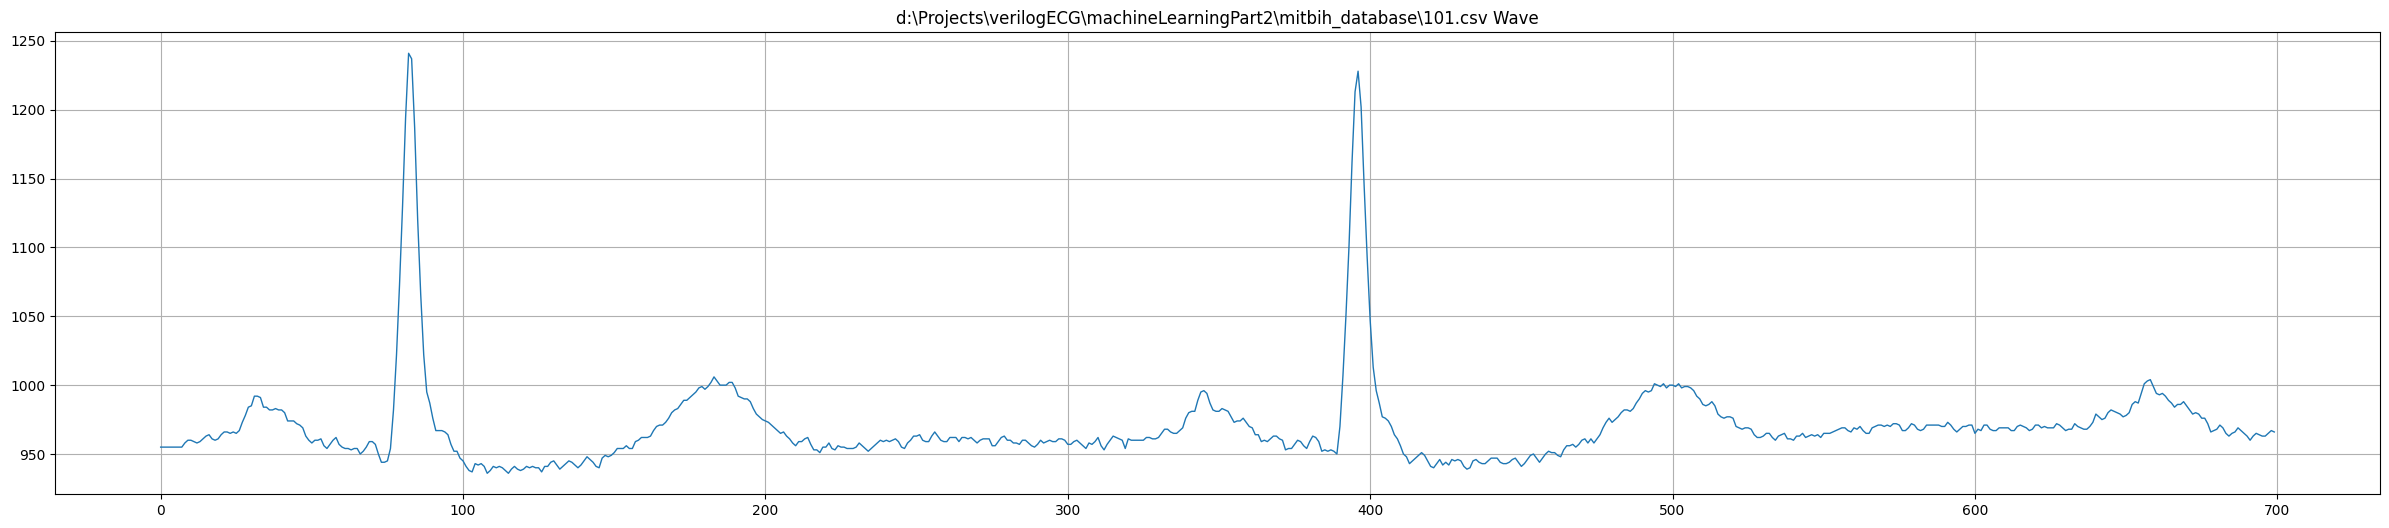

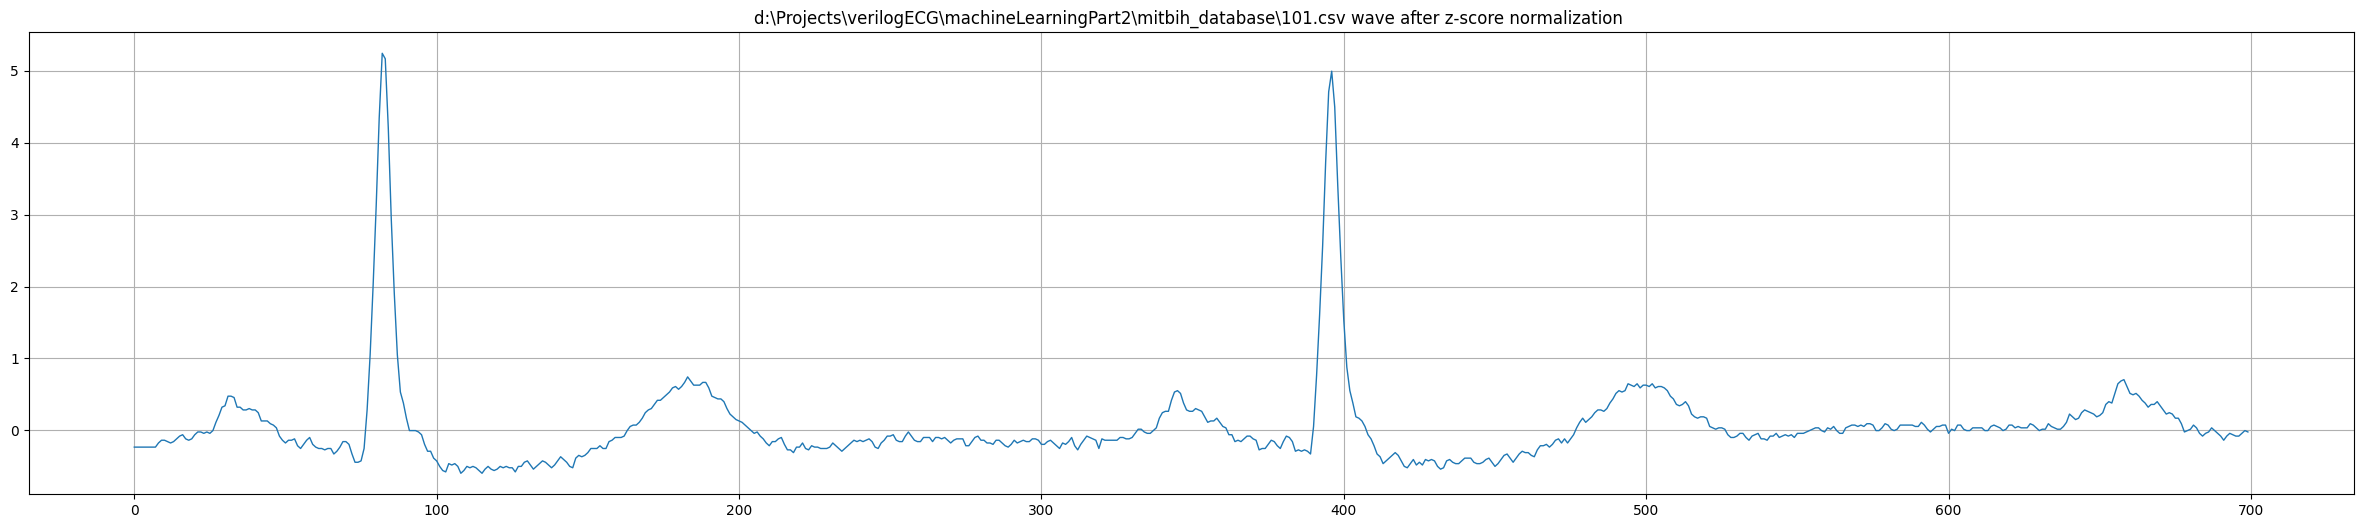

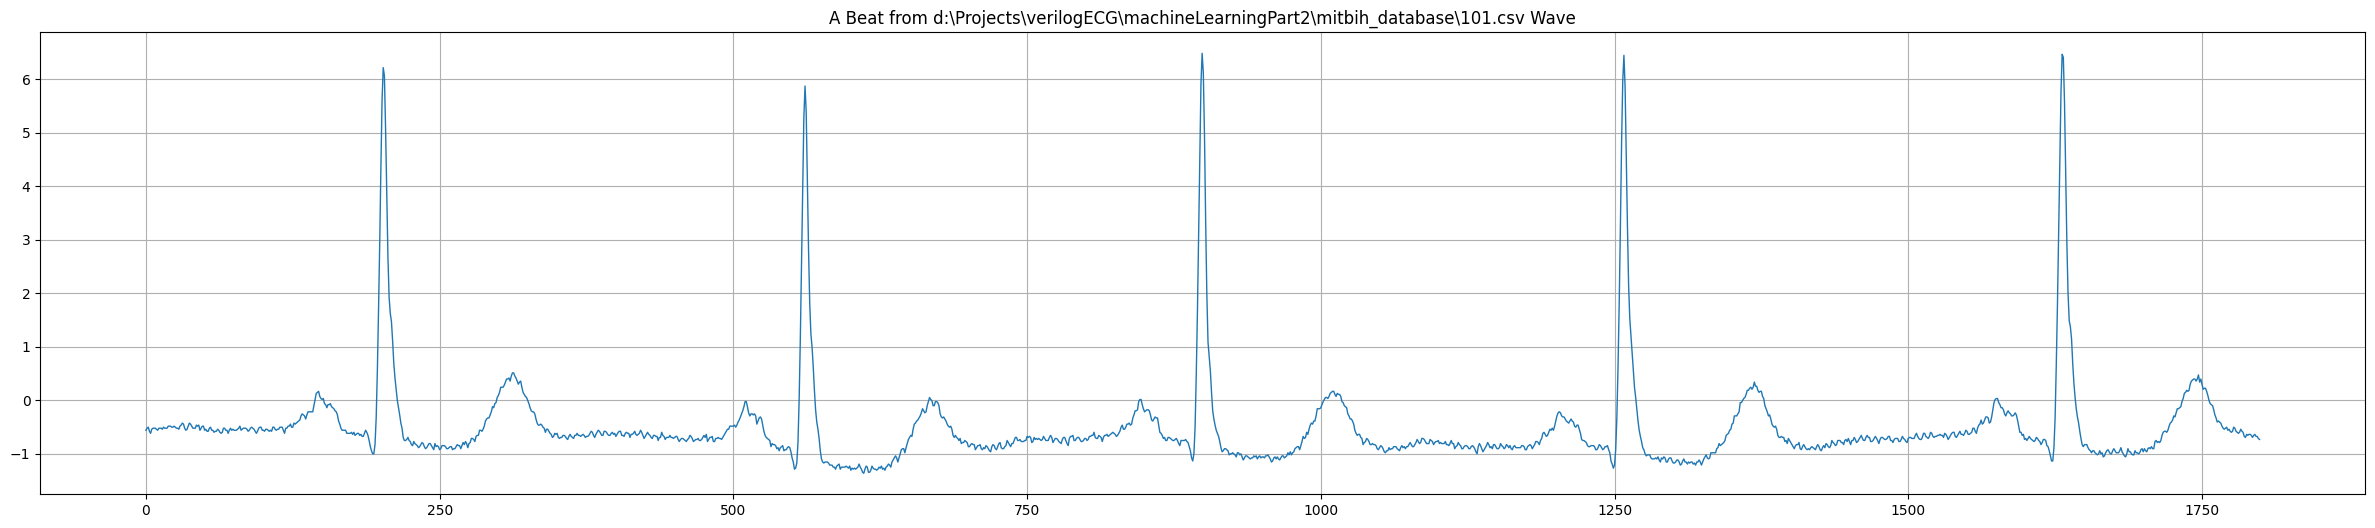

(199, 1800) (199,)


In [4]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    
    stride = 450
    
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data), stride):  # Step by stride
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)  # Time... Clipping
            pos = int(next(splitted))  # Sample ID
            arrhythmia_type = next(splitted)  # Type
            
            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size : pos + window_size]

                    # Plot an example of a beat
                    if r == 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


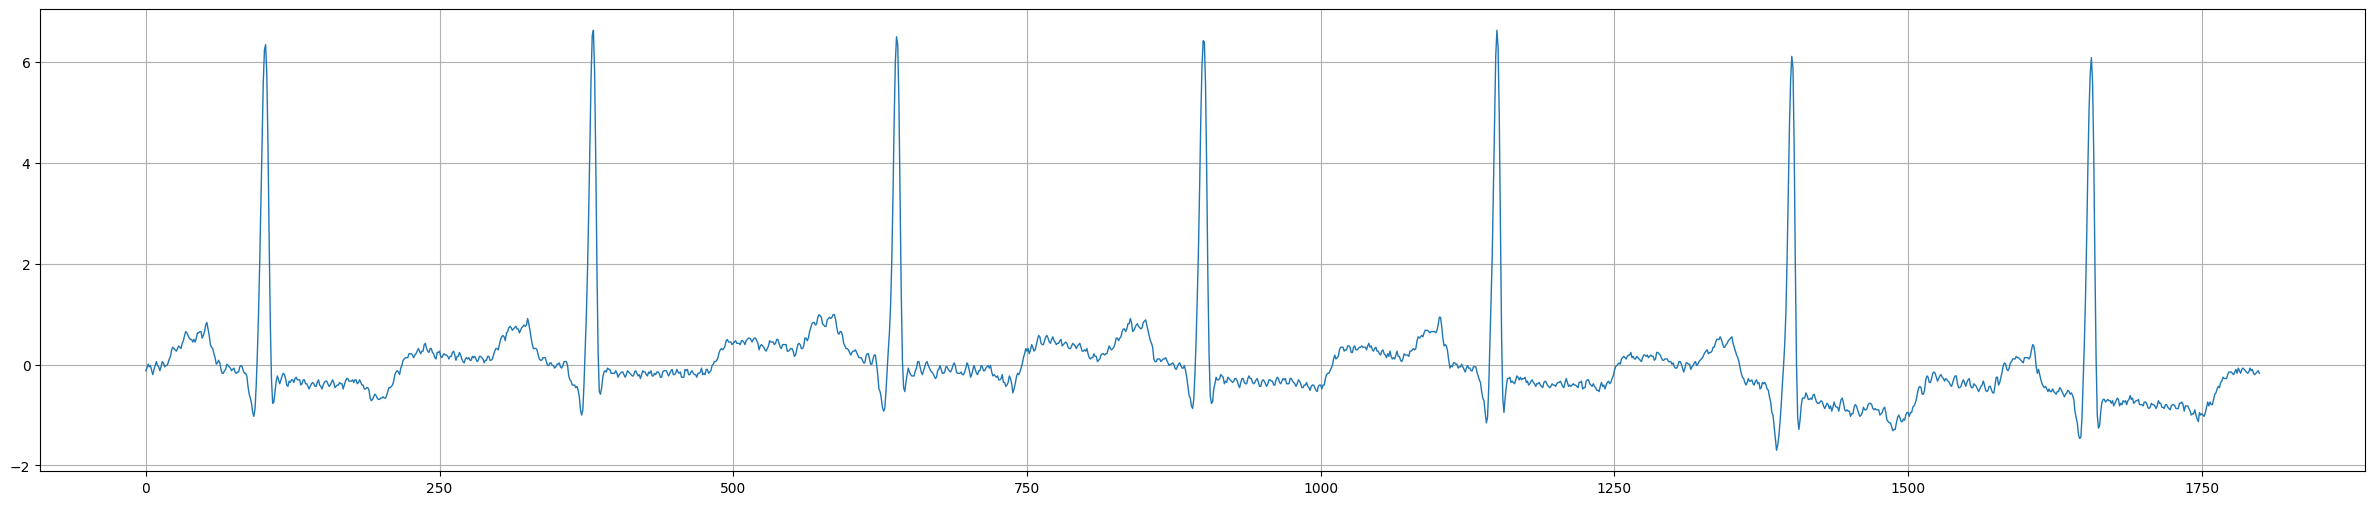

(199, 1801)
1800
0.0    147
1.0     17
4.0     15
2.0     15
3.0      5
Name: count, dtype: int64


In [5]:
plt.plot(X[0])
plt.show()
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming X_train_df is your DataFrame
min_height = 2  # Minimum peak height in scaled range

# List to store the results
results = []

# Iterate over each row in the DataFrame
for index, row in X_train_df.iterrows():
    data = row.values  # Get the values of the row

    # Min-max scale the signal to range [0, 5]
    data_min, data_max = np.min(data), np.max(data)
    if data_max > data_min:  # Avoid division by zero
        data_scaled = 5 * (data - data_min) / (data_max - data_min)
    else:
        data_scaled = np.zeros_like(data)  # If all values are the same, set to zero

    # Find peaks using the scaled data
    peaks, _ = find_peaks(data_scaled, height=min_height)

    # Calculate RR peak distances (differences between consecutive peaks)
    rr_distances = np.diff(peaks)

    # Check if there are peaks to calculate the statistics
    if len(rr_distances) > 0:
        mean_rr = np.mean(rr_distances)
        min_rr = np.min(rr_distances)
        max_rr = np.max(rr_distances)
        median_rr = np.median(rr_distances)
    else:
        # If no peaks are found, set NaN values
        mean_rr = min_rr = max_rr = median_rr = np.nan

    # Append the results to the list
    results.append([mean_rr, min_rr, max_rr, median_rr])

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Mean RR Peak Distance', 'Min RR Peak Distance', 'Max RR Peak Distance', 'Median RR Peak Distance'])
print(results_df)

# Check for NaN values
if results_df.isnull().values.any():
    print("There are NaN values in the DataFrame.")
else:
    print("No NaN values in the DataFrame.")


     Mean RR Peak Distance  Min RR Peak Distance  Max RR Peak Distance  \
0               259.000000                   250                   279   
1               288.000000                   273                   307   
2               291.333333                   284                   301   
3               290.666667                   276                   307   
4               273.833333                   259                   284   
..                     ...                   ...                   ...   
194             230.833333                   228                   235   
195             237.000000                   229                   242   
196             244.666667                   239                   249   
197             244.666667                   238                   251   
198             238.166667                   229                   245   

     Median RR Peak Distance  
0                      256.5  
1                      283.5  
2                 

In [7]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import entropy

def sampen(signal, m, r, dist_type='chebyshev'):
    if len(signal) == 0:
        raise ValueError("Signal cannot be empty.")
    if not isinstance(signal, (list, np.ndarray)):
        raise ValueError("Signal must be a list or NumPy array.")
    if not isinstance(dist_type, str):
        raise ValueError("Distance type must be a string.")
    if m >= len(signal):
        raise ValueError("Embedding dimension must be smaller than the signal length (m < N).")
    
    signal = np.asarray(signal).flatten()
    N = len(signal)
    sigma = np.std(signal)
    
    # Create the matrix of matches
    matches = np.full((m + 1, N), np.nan)
    for i in range(m + 1):
        matches[i, :N - i] = signal[i:]
    matches = matches.T
    
    # Check the matches for m
    d_m = pdist(matches[:, :m], metric=dist_type)
    if d_m.size == 0:
        return float('inf')
    
    # Check the matches for m+1
    d_m1 = pdist(matches[:, :m + 1], metric=dist_type)
    
    # Compute A and B
    B = np.sum(d_m <= r * sigma)
    A = np.sum(d_m1 <= r * sigma)
    
    # Sample entropy calculation
    if A == 0 or B == 0:
        return -np.log(2 / ((N - m - 1) * (N - m)))
    
    return -np.log((A / B) * ((N - m + 1) / (N - m - 1)))

# Function to compute Shannon entropy
def shannon_entropy(signal):
    signal = np.asarray(signal)
    _, counts = np.unique(signal, return_counts=True)
    prob = counts / len(signal)
    return entropy(prob, base=2)  # Shannon entropy in base 2

# Assuming X_train_df and results_df are already defined
sampen_list = []
shannon_entropy_list = []

for index, row in X_train_df.iterrows():
    signal = row[:-1].values  # Exclude the last element (label)
    
    # Calculate Sample Entropy
    sampen_value = sampen(signal, m=2, r=0.2)  # Example values for m and r
    sampen_list.append(sampen_value)
    
    # Calculate Shannon Entropy
    shannon_value = shannon_entropy(signal)
    shannon_entropy_list.append(shannon_value)

# Add the entropy values to the results DataFrame
results_df['Sample_Entropy'] = sampen_list
results_df['Shannon_Entropy'] = shannon_entropy_list
results_df['Label'] = y
print(results_df.columns)


Index(['Mean RR Peak Distance', 'Min RR Peak Distance', 'Max RR Peak Distance',
       'Median RR Peak Distance', 'Sample_Entropy', 'Shannon_Entropy',
       'Label'],
      dtype='object')


In [8]:
from sklearn.model_selection import train_test_split

# Assuming 'results_df' contains the features and the labels
a = results_df[['Mean RR Peak Distance', 'Min RR Peak Distance', 'Max RR Peak Distance', 'Median RR Peak Distance', 'Sample_Entropy', 'Shannon_Entropy']]
b = results_df['Label']

# Split the data into train and test datasets (e.g., 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.2, random_state=42)



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Preprocess the data and convert to PyTorch tensors
# Convert to PyTorch tensors without scaling
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).cuda() if torch.cuda.is_available() else torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).cuda() if torch.cuda.is_available() else torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).cuda() if torch.cuda.is_available() else torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).cuda() if torch.cuda.is_available() else torch.tensor(y_test.values, dtype=torch.long)
# Scale the data using StandardScaler



In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

# Define the input, hidden, and output sizes
input_size = X_train_tensor.shape[1]  # Number of features
hidden_size = 64  # Example hidden layer size
output_size = len(y_train.unique())  # Number of unique labels

# Step 3: Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size).cuda() if torch.cuda.is_available() else MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [5/100], Loss: 0.6170
Epoch [10/100], Loss: 0.6168
Epoch [15/100], Loss: 0.6163
Epoch [20/100], Loss: 0.6159
Epoch [25/100], Loss: 0.6153
Epoch [30/100], Loss: 0.6152
Epoch [35/100], Loss: 0.6147
Epoch [40/100], Loss: 0.6145
Epoch [45/100], Loss: 0.6139
Epoch [50/100], Loss: 0.6134
Epoch [55/100], Loss: 0.6132
Epoch [60/100], Loss: 0.6128
Epoch [65/100], Loss: 0.6123
Epoch [70/100], Loss: 0.6121
Epoch [75/100], Loss: 0.6116
Epoch [80/100], Loss: 0.6112
Epoch [85/100], Loss: 0.6104
Epoch [90/100], Loss: 0.6102
Epoch [95/100], Loss: 0.6099
Epoch [100/100], Loss: 0.6098


In [30]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.size(0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
predicted

Test Accuracy: 70.00%


tensor([0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0], device='cuda:0')